In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import itertools
sys.path.append("/mnt/ssd/NMRlipids_VI-NewIonModel/scripts/")
import calcOrderParameters as cop
import fnmatch
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [14]:
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
    supplied root directory.'''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield os.path.join(path, filename)
            

In [15]:
class Simulation():
    '''Simulation class stores simulation data relevant for NMRlipids project 6'''
    def __init__(self, dirname, 
                 ordpars_fname="OrdPars.dat", 
                 dens_fname="density_ca_cl_water.xvg", 
                 conc_bulk_fname="conc_ion_bulk_mmolL.dat", 
                 conc_nominal_fname="conc_ion_nominal_mmolL.dat"):
        self.dirname = dirname
        self.ordpars = cop.parse_op_input(os.path.join(dirname, ordpars_fname))
        try:
            self.dens    = np.loadtxt(os.path.join(dirname, dens_fname))
            self.conc_bulk = np.loadtxt(os.path.join(dirname, conc_bulk_fname))
            self.conc_nominal = np.loadtxt(os.path.join(dirname, conc_nominal_fname))
        except:
            print "Simulation in \n {d} \n has no densities or files with concentrations, setting concentrations to 0.".format(d=self.dirname)
            self.conc_bulk = np.zeros([2])
            self.conc_nominal = 0.0
                    

Finding all simulations with ECC-POPC and cationic surfactant

In [16]:
sim_dirs = []
for f in locate("OrdPars.dat", root=os.curdir+"/NpT"):
    if "sim22a_0mM" in f and "NaCl" in f and "SPCE" in f:
        sim_dirs.append(os.path.dirname(f))
    if "sim22_T7H-ECC" in f and "SPCE" in f and not "MODEL_LIPID14" in f:
        sim_dirs.append(os.path.dirname(f))

for f in sim_dirs:
    if "300K" in f:
        sim_dirs.remove(f)
        
sim_dirs.sort()
#print sim_dirs

In [17]:
sims = []
for d in sim_dirs:
    sim = Simulation(d)
    sims.append(sim)

Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/NpT/sim22a_0mM_NaCl_SPCE_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref 
 has no densities or files with concentrations, setting concentrations to 0.


getting PN_vector data from ECC-POPC simulations

In [18]:
opsdata = {}
# regular expressions explained at https://docs.python.org/2/howto/regex.html#match-versus-search
p = re.compile('\d+p_')  # string pattern for molar fraction in %
for s in sims:
    if "T7H" in s.dirname:
        m = p.search(s.dirname)
        s.conc_bulk[0] = float(m.group()[0:2])
    for opname in ["alpha1", "alpha2", "beta1", "beta2", "PN_vector", "g3_1", "g3_2"]:
        temp_list = []
        try:
            temp_list.append([s.conc_bulk[0], float(s.ordpars[opname].avg)])
            print s.conc_bulk[0], float(s.ordpars[opname].avg), float(s.ordpars[opname].errest)
        except:
            print "Simulation in dir \n {d} \n seem to have no record of the order parameter {op} -- skipping".format(d=s.dirname, op=opname)
        if opname in opsdata.keys():
            opsdata[opname].extend(temp_list)
        else:
            opsdata[opname] = temp_list
            

print opsdata

20.0 -0.03642 0.00121
20.0 -0.03681 0.0012
20.0 -0.06677 0.00118
20.0 -0.06617 0.00118
20.0 65.66728 0.10109
20.0 -0.15237 0.00101
20.0 -0.15649 0.00097
30.0 -0.05256 0.00119
30.0 -0.05124 0.00119
30.0 -0.07525 0.00116
30.0 -0.0742 0.00117
30.0 64.04373 0.10403
30.0 -0.13208 0.00105
30.0 -0.14661 0.00098
42.0 -0.07416 0.00081
42.0 -0.07126 0.00082
42.0 -0.0823 0.00081
42.0 -0.07933 0.00082
42.0 61.98833 0.07618
42.0 -0.12879 0.00074
42.0 -0.14289 0.0007
50.0 -0.11013 0.00109
50.0 -0.10894 0.00109
50.0 -0.09941 0.00112
50.0 -0.09859 0.00112
50.0 58.46977 0.11339
50.0 -0.16601 0.00097
50.0 -0.12254 0.001
0.0 0.01386 0.00112
0.0 0.01452 0.00111
0.0 -0.04224 0.00106
0.0 -0.04445 0.00106
0.0 71.66272 0.07961
0.0 -0.16101 0.00089
0.0 -0.17757 0.00083
{'alpha2': [[20.0, -0.03681], [30.0, -0.05124], [42.0, -0.07126], [50.0, -0.10894], [0.0, 0.01452]], 'alpha1': [[20.0, -0.03642], [30.0, -0.05256], [42.0, -0.07416], [50.0, -0.11013], [0.0, 0.01386]], 'g3_2': [[20.0, -0.15649], [30.0, -0.14661],

Using variables formerly for Lipid14 for ECC-Lipids_openMM simulations -- dirty hack!!!
---

Redoing the file search again for the reference simulations set (i.e. Lipid14)

In [19]:
#REUSING sim_dirs!!
sim_dirs = []
for f in locate("OrdPars_omm.dat", root=os.curdir+"/NpT"):
    if "sim22a_0mM" in f and "NaCl" in f and "SPCE" in f:
        sim_dirs.append(os.path.dirname(f))
    if "sim22_T7H-ECC" in f and "SPCE" in f and not "MODEL_LIPID14" in f:
        sim_dirs.append(os.path.dirname(f))

for f in sim_dirs:
    if "300K" in f:
        sim_dirs.remove(f)
        
sim_dirs.sort()
sims_l14 = []
for d in sim_dirs:
    sim = Simulation(d, ordpars_fname="OrdPars_omm.dat")
    sims_l14.append(sim)

Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/NpT/sim22a_0mM_NaCl_SPCE_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref 
 has no densities or files with concentrations, setting concentrations to 0.


getting PN_vector data from Lipid14 simulations

In [20]:
opsdata_l14 = {}
# regular expressions explained at https://docs.python.org/2/howto/regex.html#match-versus-search
p = re.compile('\d+p_')  # string pattern for molar fraction in %
for s in sims_l14:
    if "T7H" in s.dirname:
        m = p.search(s.dirname)
        s.conc_bulk[0] = float(m.group()[0:2])
    for opname in ["alpha1", "alpha2", "beta1", "beta2", "PN_vector", "g3_1", "g3_2"]:
        temp_list = []
        try:
            temp_list.append([s.conc_bulk[0], float(s.ordpars[opname].avg)])
            print s.conc_bulk[0], float(s.ordpars[opname].avg), float(s.ordpars[opname].errest)
        except:
            print "Simulation in dir \n {d} \n seem to have no record of the order parameter {op} -- skipping".format(d=s.dirname, op=opname)
        if opname in opsdata_l14.keys():
            opsdata_l14[opname].extend(temp_list)
        else:
            opsdata_l14[opname] = temp_list
            

print opsdata_l14

20.0 -0.04437 0.00085
20.0 -0.04197 0.00085
20.0 -0.07156 0.00083
20.0 -0.07047 0.00083
20.0 65.34451 0.07267
20.0 -0.16413 0.0007
20.0 -0.16416 0.00068
30.0 -0.05768 0.00083
30.0 -0.05456 0.00084
30.0 -0.07561 0.00082
30.0 -0.07379 0.00082
30.0 63.91985 0.07411
30.0 -0.14718 0.00072
30.0 -0.15344 0.00069
42.0 -0.08036 0.00081
42.0 -0.07721 0.00081
42.0 -0.08564 0.00081
42.0 -0.08531 0.00081
42.0 61.12612 0.07645
42.0 -0.14145 0.00073
42.0 -0.13809 0.00071
50.0 -0.11859 0.00076
50.0 -0.1174 0.00076
50.0 -0.10368 0.00079
50.0 -0.10402 0.00078
50.0 57.74545 0.08082
50.0 -0.14942 0.00071
50.0 -0.11519 0.00073
0.0 0.01323 0.00064
0.0 0.01166 0.00064
0.0 -0.04441 0.00061
0.0 -0.04621 0.00061
0.0 71.7126 0.04607
0.0 -0.16296 0.00051
0.0 -0.18532 0.00047
{'alpha2': [[20.0, -0.04197], [30.0, -0.05456], [42.0, -0.07721], [50.0, -0.1174], [0.0, 0.01166]], 'alpha1': [[20.0, -0.04437], [30.0, -0.05768], [42.0, -0.08036], [50.0, -0.11859], [0.0, 0.01323]], 'g3_2': [[20.0, -0.16416], [30.0, -0.15344

getting experimental results from Scherer89

In [21]:
exp_filenames = []
experiments = {}
freq_to_scd = 0.00748
# find files with the experimental values as read from figure4 in scherer89
for f in locate("sceherer89fig4*C16.dat", root=os.curdir+"/../../../Data"):
    exp_filenames.append(f)
    freq_sign = 1.0
    if "ALPHA" in f:
        op_name = 'alpha'
    elif "BETA" in f:
        op_name = 'beta'
        freq_sign = -1.0
    else:
        print "There's no string >ALPHA< nor >BETA< in file \n {}\n This should not happen, check code...".format(f)
    # load data into numpy array: col0=c, col1=NMR_frequency
    experiments[op_name] = np.loadtxt(f)
    # convert col1 to contain S_CD with a correct sign -- this is specific to these data
    experiments[op_name][:,1] *= freq_to_scd*freq_sign
    # convert col0 to contain concentrations in %-unit
    experiments[op_name][:,0] *= 100.0
    
print experiments
        

{'alpha': array([[ -1.63322445e-01,   8.24615026e-04],
       [  6.21733551e+00,  -1.71978668e-02],
       [  1.19056230e+01,  -2.75345377e-02],
       [  2.00950770e+01,  -4.13117792e-02],
       [  3.12418339e+01,  -6.00641357e-02],
       [  3.80832944e+01,  -8.26977302e-02],
       [  4.24125058e+01,  -9.45839044e-02],
       [  6.47031031e+01,  -1.30165762e-01],
       [  7.05832944e+01,  -1.17426302e-01],
       [  9.12418339e+01,  -1.24178421e-01]]), 'beta': array([[ -1.63322445e-01,  -8.24615026e-04],
       [  3.91682221e+00,  -3.55026998e-03],
       [  9.12389174e+00,  -1.12846977e-02],
       [  1.50104993e+01,  -1.97938771e-02],
       [  2.90398973e+01,  -4.52914972e-02],
       [  4.42172189e+01,  -6.19533331e-02],
       [  6.46237751e+01,  -7.17358976e-02],
       [  9.09420205e+01,  -7.34910873e-02]])}


# Plotting figure 1: PN_vector and order parameters $\alpha$ and $\beta$ depend on the amount of bound charge - cationic surfactant

# Plotting figure 2: PN_vector and order parameters $\alpha$, $\beta$, and $g_3$ depend on the amount of bound charge - cationic surfactant

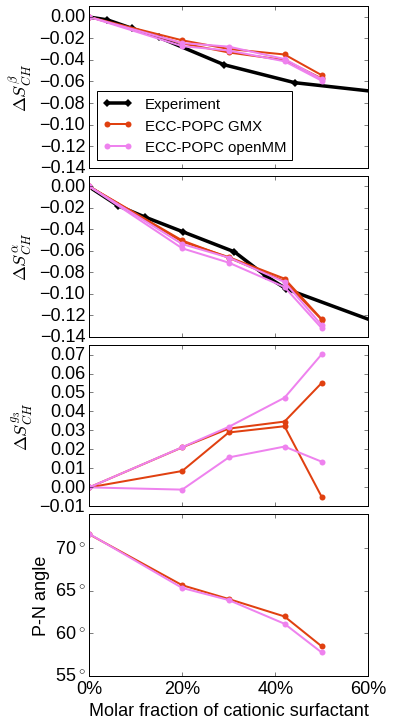

In [22]:
font = {'family' : 'Liberation Sans',
        'style'  : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axs = plt.subplots(nrows=4, ncols=1, 
                        sharex="all", figsize=[5,12], 
                        dpi=200)
fig.subplots_adjust(hspace=0.05)
#fig.subplotpars.left = 0.3

# give subplots human-redable names
dsa = axs[1] # Delta S alpha
dsb = axs[0] # Delta S beta
dsg = axs[2] # Delta S g_3
pna = axs[3] # PN_vector

# add some text for labels, title and axes ticks
pna.set_xlabel(r'Molar fraction of cationic surfactant')
pna.set_ylabel(r'P-N angle')
dsa.set_ylabel(r'$\Delta S_{CH} ^{\alpha}$')
dsb.set_ylabel(r'$\Delta S_{CH} ^{\beta}$')
dsg.set_ylabel(r'$\Delta S_{CH} ^{g_3}$')

pna.set_xlim([0.0,60.0])
#ax.set_xticks(r1)
#xlabelsl = list(xlabels)
#xlabelsl.extend(range(2, 18))
#ax.set_xticklabels(xlabelsl, rotation=0)

for (opsplot, c, label) in zip([experiments, opsdata, opsdata_l14], 
                               ["black", "#e04010", "violet", "#608010"], 
                               ["Experiment", "ECC-POPC GMX", "ECC-POPC openMM"]):

    for key in opsplot.keys():
        yerror = 0.001
        do_delta = False
        if key.startswith("alpha"):
            iplt = 1
            do_delta = True
            ylim = [-0.14, 0.01]
        elif key.startswith("beta"):
            iplt = 0
            do_delta = True
            ylim = [-0.14, 0.01]
        elif key.startswith("g3"):
            iplt = 2
            do_delta = True
            ylim = [-0.01, 0.075]
        elif key.startswith("PN"):
            iplt = 3
            yerror = 0.15
            ylim = [55.0, 74.0]
        else:
            print "this should not happen, setting iplt = 2"
            iplt = 2
        ax = axs[iplt]
        ax.set_ylim(ylim)
        if isinstance(opsplot[key], list):
            opsplot[key].sort()
        else:
            #print "this is not list, not sorting. It's likely the experimental data."
            pass
        data = np.array(opsplot[key])
        if do_delta:
            data[:,1] -= data[0,1]
        #ax.errorbar(data[:,0], data[:,1], yerr=yerror, lw=2.0, marker='s', markersize=5, mew=0, color=c) #, c=colour, lw=1.0, label=point_label)
        if key=="beta" or key=="beta1":
            plot_label = label
        else:
            plot_label = None
        if "Exp" in label:
            linew = 3.50
            marker = "D"
        else:
            linew = 2.0
            marker = "o"
        if not data.shape==(0,):
            ax.plot(data[:,0], data[:,1], lw=linew, marker=marker, markersize=6, mew=0, color=c, label=plot_label) #, c=colour, lw=1.0, label=point_label)

            
xlim = pna.get_xlim()
pna.set_xticks(range(0,90,20))
pna.set_xticklabels([ str(i)+r"%" for i in range(0,90,20)])
pna.set_xlim(xlim)

ylim = pna.get_ylim()
pna.set_yticks(range(0,90,5))
pna.set_yticklabels([ str(i)+r"$^\circ$" for i in range(0,90,5)])
pna.set_ylim(ylim)

dsb.legend(loc="lower left", markerscale=1.0, scatterpoints=4, fontsize='small')

plt.savefig("PN_angle_OrdPars-A-B-g3_L14-ECCL17_q80_sig89_surf_GMX-oMM_compar.pdf", dpi=200, bbox_inches='tight')
plt.show()
